In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

zsh:1: command not found: wget


In [8]:
df=pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates=["Date"],index_col=["Date"])
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv'

In [ ]:
bitcoin_prices= pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)" : "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


<Axes: xlabel='Date'>

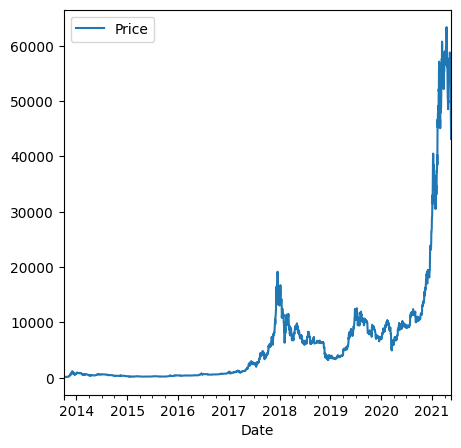

In [ ]:
import matplotlib.pyplot as plt
timestamps = bitcoin_prices.index.to_numpy()
prices= bitcoin_prices.Price.to_numpy()
bitcoin_prices.plot(figsize=(5,5))

In [ ]:
def get_labelled_windows(x, horizon = 1): #set horizon as 1 day
    return x[:,:-horizon], x[:, -horizon:]


def make_windows(x, window_size=7, horizon=1):
    """
    Turns a 1D array into a 2D array of sequential windows of window_size.
    """
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

def mean_absolute_scaled_error(y_true, y_pred):
    '''
    No seasonality is assumed
    '''
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive_no_season

def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
        plt.grid(True)

def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

def make_preds(model, data):
    return tf.squeeze(model.predict(data))

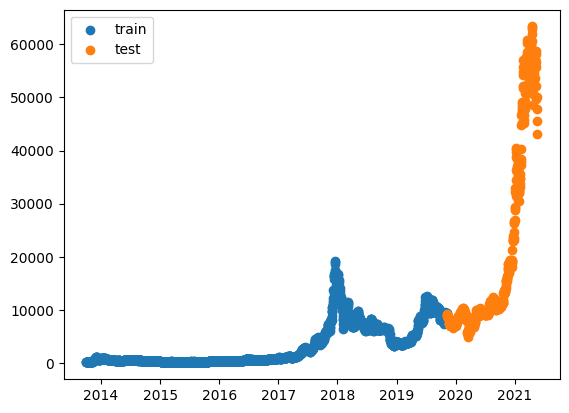

In [ ]:
split_size = int(0.8 * len(prices))
x_train,  y_train = timestamps[:split_size], prices[:split_size]
x_test,  y_test = timestamps[split_size:], prices[split_size:]

plt.scatter(x_train, y_train, label = 'train')
plt.scatter(x_test, y_test, label = 'test')
plt.legend()

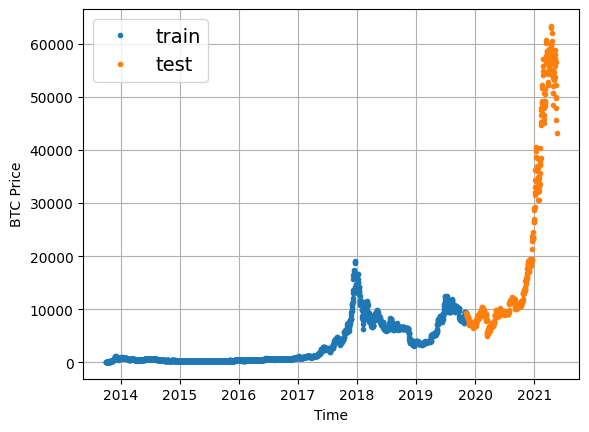

In [ ]:
plot_time_series(x_train, y_train, label='train')
plot_time_series(x_test, y_test, label='test')

In [ ]:
#Naive Model

naive_forecast = y_test[:-1]
naive_forecast[:5], y_test[:5] #basically the same

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917]),
 array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917]))

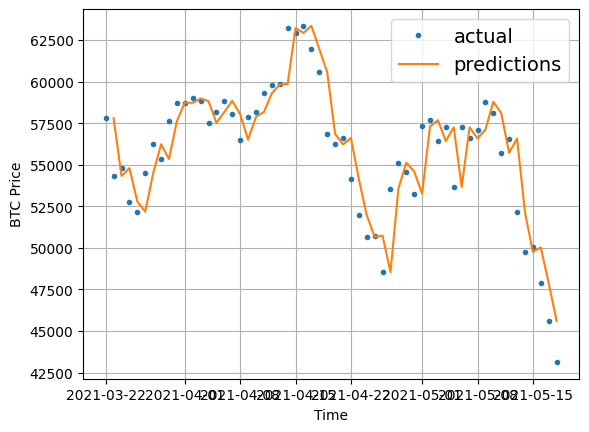

In [ ]:
offset = 500
plot_time_series(x_test, y_test, start = offset, label='actual')
plot_time_series(x_test[1:], naive_forecast, start = offset, format = "-", label='predictions')

In [ ]:
model_0_results = evaluate_preds(y_test[1:], naive_forecast)
model_0_results
'''
MAPE is Mean Absolute Percentage Error which is quite small here
MASE is Mean Absolute Scaled Error which is really small here
'''

'\nMAPE is Mean Absolute Percentage Error which is quite small here\nMASE is Mean Absolute Scaled Error which is really small here\n'

In [ ]:
full_windows, full_labels = make_windows(prices)

In [ ]:
for i in range(3):
  print(f"Window: {full_windows[i]} --> {full_labels[i]}") #3 windows being displayed here

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] --> [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] --> [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] --> [125.96116]


In [ ]:
len(full_windows)

2780

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows)

(2224, 556)

In [ ]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='linear') #no classification at output layer so we follow default actiavtion as linear function
])
model_1.compile(loss=tf.keras.losses.mae,
                optimizer= tf.keras.optimizers.Adam(),
                metrics=['mae'])
history_1= model_1.fit(train_windows, train_labels,
                       epochs=100,
                       validation_data=(test_windows, test_labels),
                       batch_size=128)

Epoch 1/100
18/18 [==============================] - 1s 13ms/step - loss: 1888.3889 - mae: 1888.3889 - val_loss: 1728.4193 - val_mae: 1728.4193
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 401.3539 - mae: 401.3539 - val_loss: 1576.4292 - val_mae: 1576.4292
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 196.5492 - mae: 196.5492 - val_loss: 1014.4446 - val_mae: 1014.4445
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 159.2752 - mae: 159.2752 - val_loss: 869.2444 - val_mae: 869.2444
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 152.2565 - mae: 152.2565 - val_loss: 830.5123 - val_mae: 830.5123
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 143.8571 - mae: 143.8571 - val_loss: 844.9996 - val_mae: 844.9996
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 133.7012 - mae: 133.7012 - val_loss: 710.0958 - val_mae: 710.0958
Epoch 8/100
18/18 

In [ ]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 612.6351 - mae: 612.6351


[612.6351318359375, 612.6351318359375]

In [ ]:
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                512       
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8897 (34.75 KB)
Trainable params: 8897 (34.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8710.626, 8667.347, 8951.017, 8669.259, 8640.526, 8638.421,
       8555.819, 8414.672, 8357.4  , 8427.714], dtype=float32)>

In [ ]:
model_1_results = evaluate_preds(tf.squeeze(test_labels), model_1_preds)
model_1_results

{'mae': 612.6351,
 'mse': 1233716.4,
 'rmse': 1110.7278,
 'mape': 2.7948217,
 'mase': 1.0762302}

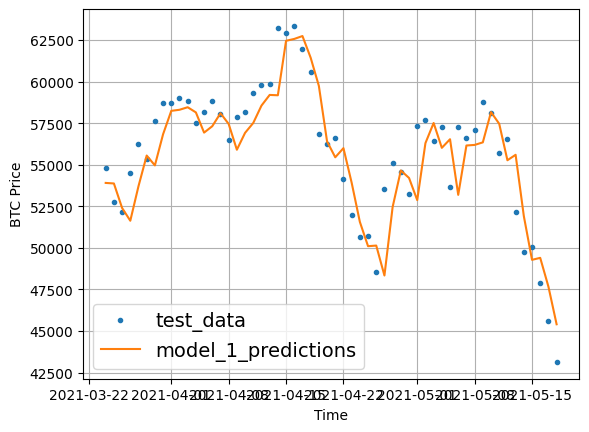

In [ ]:
plot_time_series(x_test[-len(test_windows):], test_labels[:, 0], start = 500, label = 'test_data')
plot_time_series(x_test[-len(test_windows):], model_1_preds, start = 500, format = '-', label = 'model_1_predictions')

In [ ]:
full_windows_30_1, full_labels_30_1 = make_windows(prices, window_size = 30) #set window size as 30 for 1 whole month of training
train_windows_30_1, test_windows_30_1, train_labels_30_1, test_labels_30_1 = make_train_test_splits(full_windows_30_1, full_labels_30_1)

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(1,activation='linear') #no classification at output layer so we follow default actiavtion as linear function
])

model_2.compile(loss=tf.keras.losses.mae,
                optimizer= tf.keras.optimizers.Adam(),
                metrics=['mae'])
history_2= model_2.fit(train_windows_30_1, train_labels_30_1,
                       epochs=100,
                       validation_data=(test_windows_30_1, test_labels_30_1),
                       batch_size=128)




Epoch 1/100
18/18 [==============================] - 1s 13ms/step - loss: 1093.5448 - mae: 1093.5448 - val_loss: 1711.2552 - val_mae: 1711.2552
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 291.8782 - mae: 291.8782 - val_loss: 1291.8463 - val_mae: 1291.8463
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 250.0505 - mae: 250.0505 - val_loss: 1298.1914 - val_mae: 1298.1914
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 243.6845 - mae: 243.6845 - val_loss: 1487.8019 - val_mae: 1487.8019
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 203.7179 - mae: 203.7179 - val_loss: 1254.3798 - val_mae: 1254.3798
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 190.8152 - mae: 190.8152 - val_loss: 924.7869 - val_mae: 924.7869
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 162.0809 - mae: 162.0809 - val_loss: 935.2548 - val_mae: 935.2548
Epoch 8/100
18

In [ ]:
model_2.evaluate(test_windows_30_1, test_labels_30_1)
#becomes worse as we increase window size and horizon in different combinations of (30, 1), (30, 7), (30, 30) and so on

18/18 [==============================] - 0s 2ms/step - loss: 836.2057 - mae: 836.2057


[836.2056884765625, 836.2056884765625]

In [ ]:
model_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 128)               3968      
                                                                 
 dense_29 (Dense)            (None, 128)               16512     
                                                                 
 dense_30 (Dense)            (None, 128)               16512     
                                                                 
 dense_31 (Dense)            (None, 1)                 129       
                                                                 
Total params: 37121 (145.00 KB)
Trainable params: 37121 (145.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_2_preds = make_preds(model_2, test_windows_30_1)
model_2_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9094.723 , 9073.502 , 8983.58  , 8842.4375, 8655.162 , 8668.353 ,
       8528.282 , 8505.601 , 8427.877 , 8031.736 ], dtype=float32)>

In [ ]:
model_2_results = evaluate_preds(tf.squeeze(test_labels_30_1), model_2_preds)
model_2_results

{'mae': 836.20575,
 'mse': 1947505.6,
 'rmse': 1395.5306,
 'mape': 4.124633,
 'mase': 1.4616959}

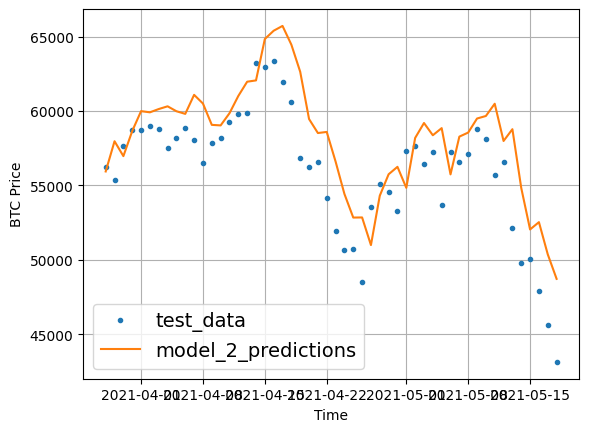

In [ ]:
plot_time_series(x_test[-len(test_windows_30_1):], test_labels_30_1[:, 0], start = 500, label = 'test_data')
plot_time_series(x_test[-len(test_windows_30_1):], model_2_preds, start = 500, format = '-', label = 'model_2_predictions')

In [ ]:

#Model 4: Conv1D with window = 7, horizon = 1

full_windows_7_1, full_labels_7_1 = make_windows(prices, window_size = 7, horizon = 1)
train_windows_7_1, test_windows_7_1, train_labels_7_1, test_labels_7_1 = make_train_test_splits(full_windows_7_1,
                                                                                                full_labels_7_1)

#we need to input shape of : (batch_size, timestamps, input_dim)
tf.expand_dims(train_labels_7_1[0], axis = 1).shape()


NameError: name 'make_windows' is not defined

In [ ]:
#create expand dims layer
expands_dims_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = 1))
expands_dims_layer(train_labels_7_1[0])

NameError: name 'train_labels_7_1' is not defined